Aditya Tripathi 202318046
Karan Sharma 202318018
Anurag Choudhury 202318059
group 6

In [28]:
pip install pyspark

In [29]:
!pip install scikit-network

In [30]:
import matplotlib.pyplot as plt
import networkx as nx
from pyspark import SparkContext
from operator import add
from sknetwork.data import karate_club, painters


In [31]:
# Initialize the Spark context
sc = SparkContext("local", "Advanced PageRank")

# Define and process your web graph as a dictionary
def compute_page_rank(link_data):
    links = sc.parallelize(link_data.items()).persist()
    links = remove_dead_ends(links)
    num_nodes = links.count()
    initial_rank = 1.0 / num_nodes
    ranks = links.map(lambda url_neighbors: (url_neighbors[0], initial_rank))

    def compute_contributions(urls, rank):
        num_urls = len(urls)
        for url in urls:
            yield (url, rank / num_urls)

    beta = 0.85
    tolerance = 1e-6
    converged = False
    iteration = 0

    while not converged and iteration < 10:
        contribs = links.join(ranks).flatMap(lambda url_urls_rank: compute_contributions(url_urls_rank[1][0], url_urls_rank[1][1]))
        new_ranks = contribs.reduceByKey(add).mapValues(lambda rank: rank * beta + (1 - beta) / num_nodes)

        # Check convergence
        if ranks.join(new_ranks).map(lambda x: abs(x[1][0] - x[1][1])).max() < tolerance:
            converged = True
        ranks = new_ranks
        iteration += 1

    return ranks.collect()

def remove_dead_ends(links):
    """Remove dead ends recursively from the graph."""
    while True:
        # Compute the out-degree for each node
        out_degrees = links.flatMap(lambda x: [(x[0], len(x[1]))] + [(y, 0) for y in x[1]]).reduceByKey(max)
        # Filter nodes that have an out-degree of zero (dead ends)
        dead_ends = out_degrees.filter(lambda x: x[1] == 0).map(lambda x: x[0]).collect()
        if not dead_ends:
            break
        # Remove dead ends from the graph
        links = links.flatMap(lambda x: [(x[0], y) for y in x[1] if y not in dead_ends]).groupByKey().mapValues(list)
    return links


In [32]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_graph(link_data, final_ranks, position=None, names=None):
    G = nx.DiGraph()

    # Initialize all nodes with a default rank to ensure there are no missing 'rank' keys.
    node_ranks = {node: rank for node, rank in final_ranks}
    for node in link_data.keys():
        rank = node_ranks.get(node, 0.0)  # Set default rank to 0.0 if not found in final_ranks
        # Safely check for labels in names if names is provided and applicable
        label = names[node] if names is not None and node < len(names) else str(node)
        G.add_node(node, rank=rank, label=label)

    # Add edges as per the link_data
    for node, neighbors in link_data.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Setup position for nodes
    if position is not None and len(position) > 0:
        if isinstance(position, np.ndarray):
            pos = {i: position[i].tolist() for i in range(len(position))}  # Ensure position is usable
        else:
            pos = {i: position[i] for i in range(len(position))}
    else:
        pos = nx.spring_layout(G)  # Calculate layout if no positions are provided

    node_color = [float(G.nodes[node]['rank']) for node in G]

    plt.figure(figsize=(10, 8))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=700, cmap=plt.cm.plasma)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, {node: G.nodes[node]['label'] for node in G.nodes()})
    plt.colorbar(nodes, label='PageRank')
    plt.title('Network Graph with PageRank')
    plt.axis('off')
    plt.show()


Custom Dataset PageRank Results: [(11, 0.12518372473204747), (0, 0.07133522974768006), (1, 0.1399244319878636), (2, 0.07345710660839436), (4, 0.04048858793484083), (6, 0.07345710660839436), (7, 0.10245428479289108), (9, 0.10447811075392885), (10, 0.07133522974768006)]


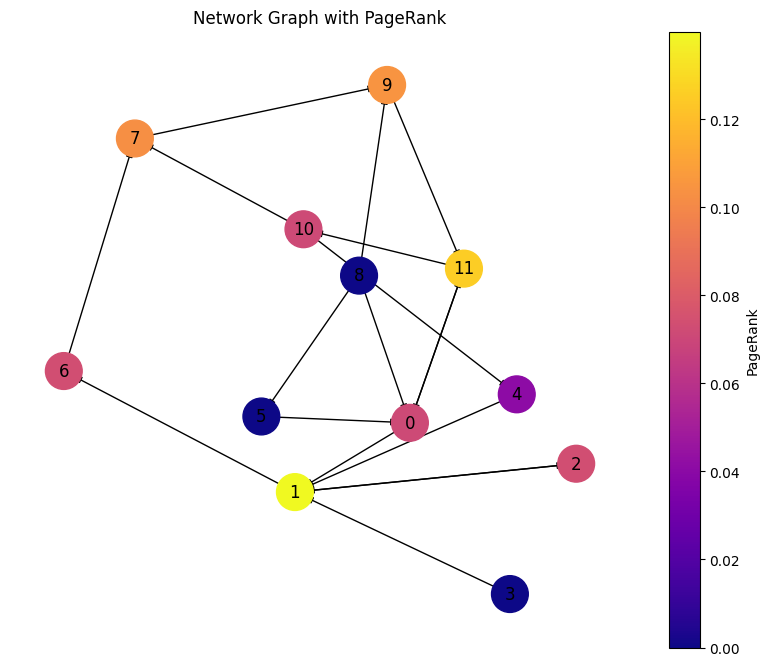

In [33]:
# Custom dataset
custom_link_data = {
    0: [1, 11],
    1: [2, 6],
    2: [1],
    3: [1],
    4: [1],
    5: [0],
    6: [7],
    7: [9],
    8: [0, 5, 9],
    9: [11],
    10: [4, 7],
    11: [0, 10]
}
custom_final_ranks = compute_page_rank(custom_link_data)


print("Custom Dataset PageRank Results:", custom_final_ranks)


plot_graph(custom_link_data, custom_final_ranks)

Karate Club Dataset PageRank Results: [(11, 0.009591392453836521), (0, 0.09683432408125801), (33, 0.10032824022909359), (22, 0.014609108561666393), (1, 0.05270896442056386), (12, 0.014671383716681103), (23, 0.03156737208822522), (2, 0.05700984924152858), (13, 0.02962050159810053), (24, 0.021037773261271597), (3, 0.03583685480385702), (14, 0.014609108561666393), (25, 0.020962943783278818), (4, 0.02204313601476537), (15, 0.014609108561666393), (26, 0.01505913384682437), (5, 0.029220283927115134), (27, 0.025665546554312527), (16, 0.016825479420855997), (6, 0.029220283927115134), (17, 0.01460543836293604), (28, 0.019579305879488463), (7, 0.02453785662961431), (18, 0.014609108561666393), (29, 0.026315470010195345), (8, 0.02983146692371576), (19, 0.019688083331422267), (30, 0.024656816968365372), (31, 0.037268795878143954), (9, 0.014346836678202263), (20, 0.014609108561666393), (10, 0.02204313601476537), (21, 0.01460543836293604), (32, 0.07127234878319948)]


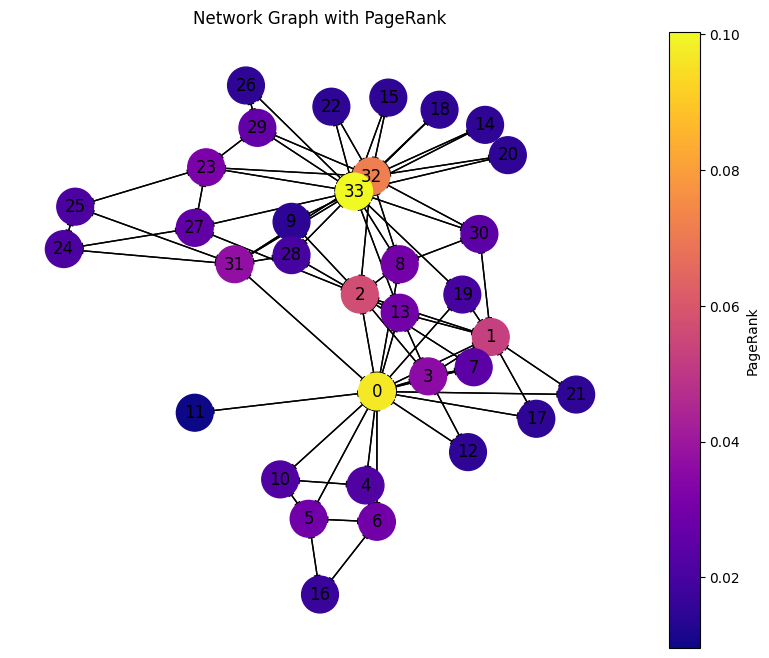

In [34]:
# Karate Club dataset
karate_graph = karate_club(metadata=True)
karate_link_data = {i: list(karate_graph.adjacency.indices[karate_graph.adjacency.indptr[i]:karate_graph.adjacency.indptr[i+1]]) for i in range(karate_graph.adjacency.shape[0])}
karate_final_ranks = compute_page_rank(karate_link_data)
print("Karate Club Dataset PageRank Results:", karate_final_ranks)
plot_graph(karate_link_data, karate_final_ranks, position=karate_graph.position)


Painters Dataset PageRank Results: [(0, 0.06039416801563977), (11, 0.0512668138929923), (1, 0.06946039445281695), (12, 0.08438379958754563), (2, 0.12498876778993409), (13, 0.01864369075381464), (3, 0.10953832377376878), (4, 0.11001955290952314), (5, 0.04712884888989093), (6, 0.01864369075381464), (7, 0.053088437933864197), (8, 0.044872833039942134), (9, 0.15675843640257367), (10, 0.050812241803879166)]


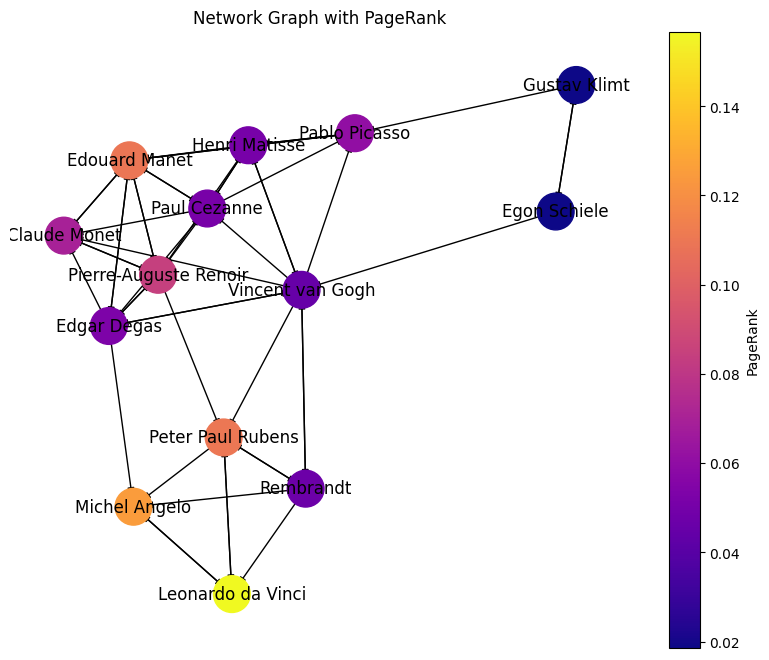

In [35]:
# Painters dataset
painter_graph = painters(metadata=True)
painter_link_data = {i: list(painter_graph.adjacency.indices[painter_graph.adjacency.indptr[i]:painter_graph.adjacency.indptr[i+1]]) for i in range(painter_graph.adjacency.shape[0])}
painter_final_ranks = compute_page_rank(painter_link_data)
print("Painters Dataset PageRank Results:", painter_final_ranks)
plot_graph(painter_link_data, painter_final_ranks, position=painter_graph.position, names=painter_graph.names)


In [36]:
sc.stop()
